Training Models...
Tuning XGBoost (Wait 30 seconds)...

Final Tuned Accuracy: 0.8003


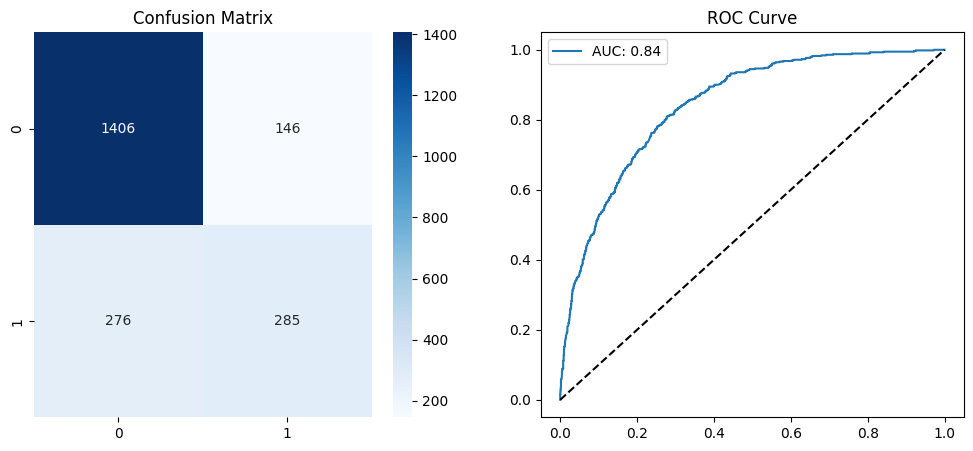

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1: RELOAD & PREPROCESS (Fixes the NameError) ---
df = pd.read_csv('../data/raw/data.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
df = df.drop('customerID', axis=1)
df['Churn'] = LabelEncoder().fit_transform(df['Churn'])
df = pd.get_dummies(df, drop_first=True)

X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- STEP 2: ADVANCED MODELING ---
print("Training Models...")
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
xgb = XGBClassifier(eval_metric='logloss', random_state=42).fit(X_train, y_train)

# --- STEP 3: HYPERPARAMETER TUNING ---
print("Tuning XGBoost (Wait 30 seconds)...")
param_grid = {'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]}
grid = GridSearchCV(XGBClassifier(eval_metric='logloss'), param_grid, cv=3).fit(X_train, y_train)
best_model = grid.best_estimator_

# --- STEP 4: RESULTS ---
final_acc = accuracy_score(y_test, best_model.predict(X_test))
print(f"\nFinal Tuned Accuracy: {final_acc:.4f}")

# --- STEP 5: VISUALS (Take Screenshots of these!) ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc_score(y_test, probs):.2f}")
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_title("ROC Curve")
ax[1].legend()
plt.show()

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 1. Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 1.0]
}

# 2. Set up the Grid Search
print("Starting Hyperparameter Tuning (this may take 1-2 minutes)...")
grid_search = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss', use_label_encoder=False),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1)

# 3. Fit the model
grid_search.fit(X_train, y_train)

# 4. Get the best model
best_xgb = grid_search.best_estimator_
tuned_pred = best_xgb.predict(X_test)

print(f"\n--- Best Parameters Found: {grid_search.best_params_} ---")
print(f"Final Tuned Accuracy: {accuracy_score(y_test, tuned_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, tuned_pred))

Starting Hyperparameter Tuning (this may take 1-2 minutes)...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


c:\Users\Mahan\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:200: UserWarning: [19:19:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Mahan\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:200: UserWarning: [19:19:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Mahan\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:200: UserWarning: [19:19:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Mahan\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:200: UserWarning: [19:19:33] WARNING: C:\actio


--- Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} ---
Final Tuned Accuracy: 0.8003

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.66      0.51      0.57       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



c:\Users\Mahan\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:200: UserWarning: [19:19:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


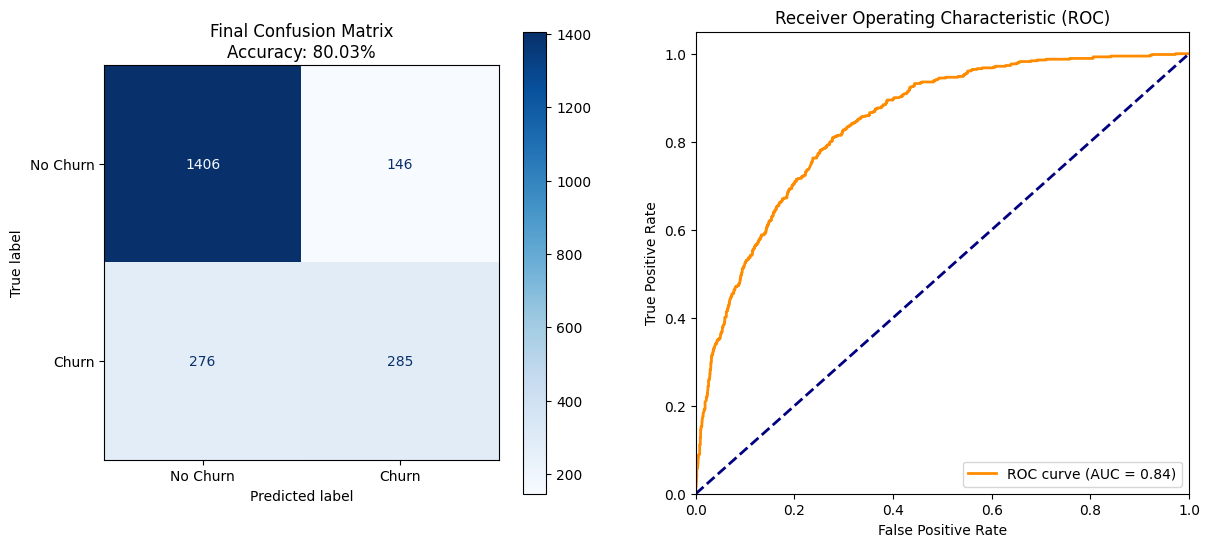

In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Calculate Probabilities (Needed for ROC Curve)
y_prob = best_xgb.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)

# 2. Set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_test, tuned_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues', ax=ax1, values_format='d')
ax1.set_title(f'Final Confusion Matrix\nAccuracy: {accuracy_score(y_test, tuned_pred):.2%}')

# 4. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC)')
ax2.legend(loc="lower right")

plt.show()